In [1]:
import os
import pickle
import numpy as np

from spenderq import load_model
from spenderq import util as U
from spenderq import lyalpha as LyA

In [2]:
# --- plotting --- 
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

## load `SpenderQ` models

In [3]:
niter = 3 

models = [] 
for imodel in range(5): 
    # load model
    _models, losses = load_model('/tigress/chhahn/spender_qso/models/london.lfsc.rsnr.sa1p1sb0p8.i%i.%i.pt' % (niter, imodel))
    models.append(_models[0])

/home/chhahn/projects/SpenderQ/src/spenderq/__init__.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_struct = torch.load(filename, map_location=device)


import torch

for ibatch in range(10): 
    # load batch
    with open('/tigress/chhahn/spender_qso/train/london.lfsc.rsnr.sa1p1sb0p8.i%i_%i.pkl' % (niter, ibatch), "rb") as f:            
        spec, w, z, target_id, norm, zerr = pickle.load(f)

    for imodel in range(5): 
        
        with torch.no_grad():
            models[imodel].eval()

            s = models[imodel].encode(spec)
            recon = models[imodel].decode(s)
            
        np.save('/tigress/chhahn/spender_qso/train/london.lfsc.rsnr.sa1p1sb0p8.i%i.%i_%i.latents.npy' % 
                (niter, imodel, ibatch), s)
        np.save('/tigress/chhahn/spender_qso/train/london.lfsc.rsnr.sa1p1sb0p8.i%i.%i_%i.recons.npy' % 
                (niter, imodel, ibatch), recon)

In [4]:
spec, w, z, target_id, norm = [], [], [], [], []
true_cont = [] 
recons = [] 

for ibatch in range(1): 
    # load batch
    with open('/tigress/chhahn/spender_qso/train/london.lfsc.rsnr.sa1p1sb0p8.i%i_%i.pkl' % (niter, ibatch), "rb") as f:    
        _spec, _w, _z, _target_id, _norm, zerr = pickle.load(f)
    spec.append(np.array(_spec))
    w.append(np.array(_w))
    z.append(np.array(_z))
    target_id.append(np.array(_target_id))    
    norm.append(np.array(_norm))

    # load true continuum
    true_cont.append(np.load('/tigress/chhahn/spender_qso/train/DESIlondon_highz_%i.true_cont.npy' % (ibatch)))

    # load SpenderQ recon 
    _recons = []  
    for imodel in range(5): 
        _recons.append(np.load('/tigress/chhahn/spender_qso/train/london.lfsc.rsnr.sa1p1sb0p8.i%i.%i_%i.recons.npy' % (niter, imodel, ibatch)))
    recons.append(np.array(_recons))
    
spec = np.concatenate(spec, axis=0)
w = np.concatenate(w)
z = np.concatenate(z)
target_id = np.concatenate(target_id)
norm = np.concatenate(norm)

true_cont = np.concatenate(true_cont, axis=0)

recons = np.concatenate(recons, axis=1)
    
w_recon = np.load('/tigress/chhahn/spender_qso/train/DESIlondon_highz.rebin.iter%i.wave_recon.npy' % niter)    

In [5]:
# load picca
picca_lya = U.london_picca('LyA')
picca_lyb = U.london_picca('LyB')

In [6]:
# select high-z and bright (high normalization) quasars
highzs = np.arange(len(z))[(z > 3.) & (norm > 2.)][:4]

/tmp/ipykernel_3934070/3691629521.py:5: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  wave_rebin = np.arange(models[0].wave_obs[0], models[0].wave_obs[-1], 10)[1:-1]


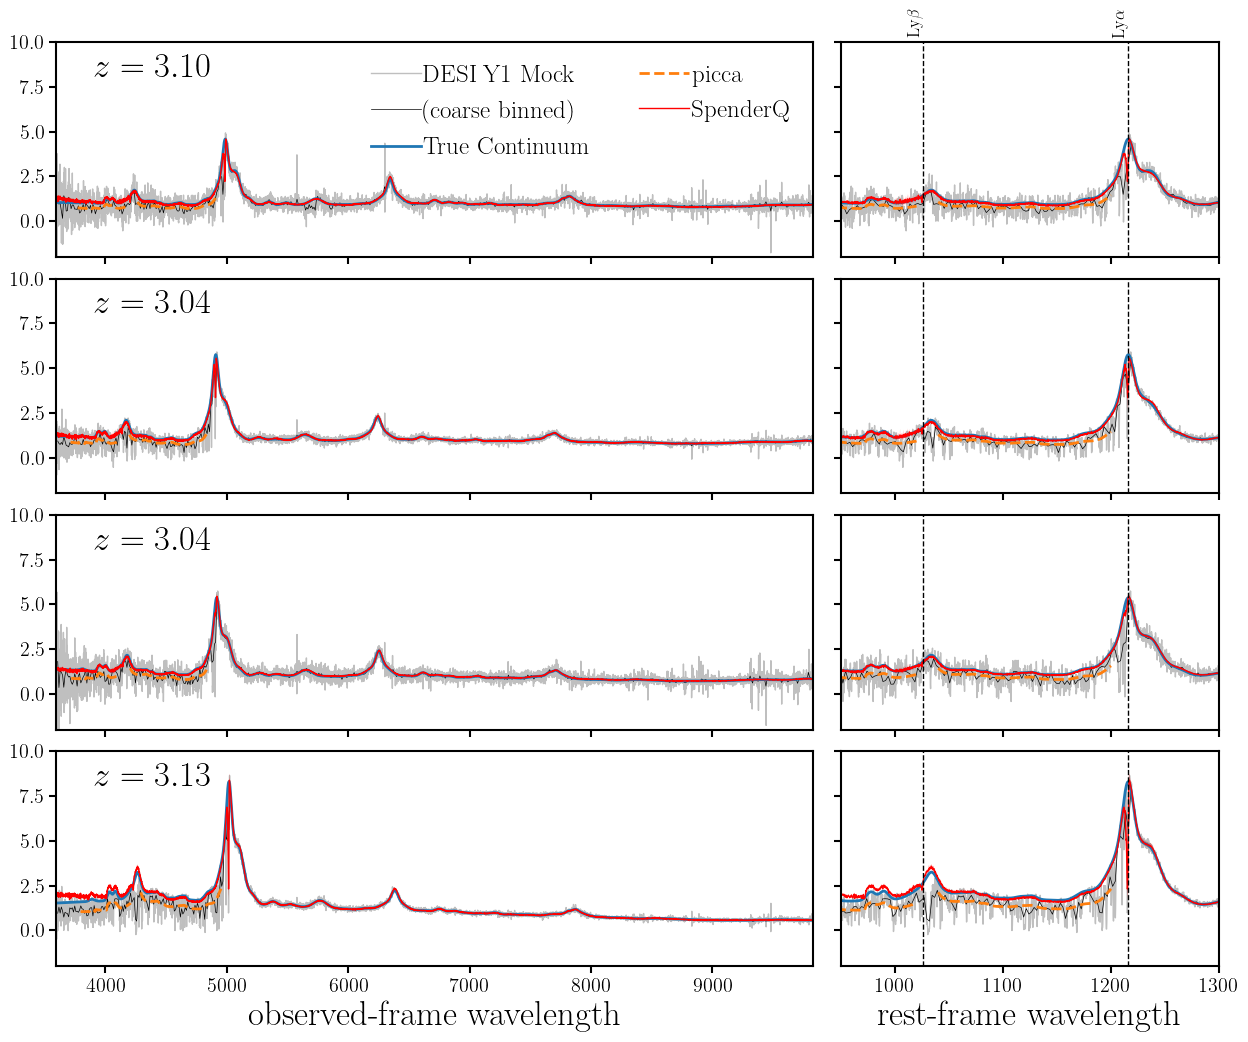

In [9]:
fig = plt.figure(figsize=(15,12))
gs = gridspec.GridSpec(len(highzs), 2, width_ratios=[2, 1]) 

# observed-frame full spectra
wave_rebin = np.arange(models[0].wave_obs[0], models[0].wave_obs[-1], 10)[1:-1]
for ii, igal in enumerate(highzs):
    sub = plt.subplot(gs[2*ii])
    
    # full spectra
    sub.plot(models[0].wave_obs, spec[igal], c='gray', alpha=0.5, lw=1, label='DESI Y1 Mock')
    
    # coarse spectra
    spec_rebin = U.trapz_rebin(np.array(models[0].wave_obs), np.array(spec[igal]), xnew=wave_rebin)
    sub.plot(wave_rebin, spec_rebin, c='k', lw=0.5, label='(coarse binned)')
    
    # true continuum
    sub.plot(np.linspace(3.50e3, 1e4, 3251), true_cont[igal]/norm[igal], c='C0', lw=2, label='True Continuum')
    
    # picca LyA
    spec_picca = picca_lya.get_continuum(int(target_id[igal]))
    sub.plot(picca_lya.wave_picca * np.array(1+z[igal]), spec_picca/norm[igal], color='C1', lw=2, ls='--', label='picca')
    
    # picca LyB
    spec_picca = picca_lyb.get_continuum(int(target_id[igal]))
    sub.plot(picca_lyb.wave_picca * np.array(1+z[igal]), spec_picca/norm[igal], color='C1', lw=2, ls='--')
    
    # spenderq recon
    sub.fill_between(models[0].wave_rest * (1+z[igal]), 
                     np.min(recons[:,igal,:], axis=0), 
                     np.max(recons[:,igal,:], axis=0), color='r', edgecolor='None', alpha=0.5)
    sub.plot(models[0].wave_rest * (1+z[igal]), np.mean(recons[:,igal,:], axis=0), color='r', lw=1, label=r'SpenderQ')    
    
    # redshift
    sub.text(0.05, 0.95, '$z=%.2f$' % z[igal], ha='left', va='top', fontsize=25, transform=sub.transAxes)

    sub.set_xlim(models[0].wave_obs[0], models[0].wave_obs[-1])
    if ii < len(highzs)-1: sub.set_xticklabels([])
    if ii == 0: sub.legend(loc='upper right', ncol=2, fontsize=18, handletextpad=0.1)
    sub.set_ylim(-2, 10.)
sub.set_xlabel("observed-frame wavelength", fontsize=25)

# zoom in rest-frame LyA region 
for ii, igal in enumerate(highzs):
    sub = plt.subplot(gs[2*ii+1])    
    sub.plot(models[0].wave_obs/(1 + z[igal]), spec[igal], c='gray', alpha=0.5, lw=1, label='DESI')
    #sub.plot((models[0].wave_obs/(1 + z[igal]))[w[igal] > 0], (spec[igal])[w[igal] > 0], c='gray', alpha=0.5, lw=1)

    spec_rebin = U.trapz_rebin(np.array(models[0].wave_obs), np.array(spec[igal]), xnew=wave_rebin)
    sub.plot(wave_rebin/(1+z[igal]), spec_rebin, c='k', lw=0.5)

    # true continuum
    sub.plot(np.linspace(3.50e3, 1e4, 3251)/(1+z[igal]), true_cont[igal]/norm[igal], c='C0', lw=2, label='True Continuum')
    
    # picca lya
    spec_picca = picca_lya.get_continuum(int(target_id[igal]))
    sub.plot(picca_lya.wave_picca, spec_picca/norm[igal], color='C1', lw=2, ls='--', label='picca')
    
    # picca lyb
    spec_picca = picca_lyb.get_continuum(int(target_id[igal]))
    sub.plot(picca_lyb.wave_picca, spec_picca/norm[igal], color='C1', lw=2, ls='--')    

    # spenderq
    sub.fill_between(models[0].wave_rest, 
                 np.min(recons[:,igal,:], axis=0), 
                 np.max(recons[:,igal,:], axis=0), color='r', edgecolor='None', alpha=0.5)
    sub.plot(models[0].wave_rest, np.mean(recons[:,igal,:], axis=0), color='r', lw=1, label=r'SpenderQ')    
    

    sub.axvline(1026, color='k', linewidth=1, linestyle='--')
    sub.axvline(1216, color='k', linewidth=1, linestyle='--')
    if ii == 0:     
        sub.text(1026, 11.8, r'Ly$\beta$', rotation=90., ha='right', va='top', fontsize=12)
        sub.text(1216, 11.8, r'Ly$\alpha$', rotation=90., ha='right', va='top', fontsize=12)

    sub.set_xlim(950., 1300.)
    if ii < len(highzs)-1: sub.set_xticklabels([])
    sub.set_ylim(-2, 10.)
    sub.set_yticklabels([])
    
sub.set_xlabel("rest-frame wavelength", fontsize=25)
fig.subplots_adjust(hspace=0.1, wspace=0.05)
plt.savefig('spenderq_mock_recon.pdf', bbox_inches='tight')

save data to file for DESI data management plan

In [7]:
output_spectra = [] 
output_spectra_rebin = []
output_spectra_true = []
output_picca_lya = [] 
output_picca_lyb = []
output_spectra_spenderq = []
output_redshifts = []

# observed-frame full spectra
wave_rebin = np.arange(models[0].wave_obs[0], models[0].wave_obs[-1], 10)[1:-1]
for ii, igal in enumerate(highzs):    
    # spectra
    output_spectra.append(np.array([np.array(models[0].wave_obs), np.array(spec)[igal]]))
    
    # coarse spectra
    spec_rebin = U.trapz_rebin(np.array(models[0].wave_obs), np.array(spec[igal]), xnew=wave_rebin)
    output_spectra_rebin.append(np.array([wave_rebin, spec_rebin]))
    
    # true continuum
    output_spectra_true.append(np.array([np.linspace(3.50e3, 1e4, 3251), true_cont[igal]/norm[igal]]))
    
    # picca LyA
    spec_picca = picca_lya.get_continuum(int(target_id[igal]))
    output_picca_lya.append(np.array([picca_lya.wave_picca * np.array(1+z[igal]), spec_picca/norm[igal]]))
    
    # picca LyB
    spec_picca = picca_lyb.get_continuum(int(target_id[igal]))
    output_picca_lyb.append(np.array([picca_lyb.wave_picca * np.array(1+z[igal]), spec_picca/norm[igal]]))
    
    # spenderq recon
    output_spectra_spenderq.append(np.array([models[0].wave_rest * (1+z[igal]), np.mean(recons[:,igal,:], axis=0)]))
    
    output_redshifts.append(z[igal])
    
    
output = {} 
output['mock_spectra'] = output_spectra
output['mock_spectra_rebin'] = output_spectra_rebin
output['true_continuum'] = output_spectra_true
output['picca_lya'] = output_picca_lya
output['picca_lyb'] = output_picca_lyb
output['spenderq_recon'] = output_spectra_spenderq
output['redshifts'] = output_redshifts

/tmp/ipykernel_1064187/2076405579.py:10: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  wave_rebin = np.arange(models[0].wave_obs[0], models[0].wave_obs[-1], 10)[1:-1]


In [12]:
import pickle

with open('fig2.p', 'wb') as f: pickle.dump(output, f)